# **DATA ANALYSIS - PH Twitter Mis/Disinformation on Redtagging**<hr>

In [367]:
# Import the necessary libraries
from typing import ItemsView
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import emoji
import emojis
import copy

import collections

import tweepy, sys, re
import sched, time, datetime
import csv, openpyxl, xlsxwriter
import pprint

import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import keras
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline


[nltk_data] Downloading package stopwords to C:\Users\Rey
[nltk_data]     Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing<hr>

Read the data

In [368]:
# Open the dataset workbook
workbook = openpyxl.load_workbook(filename = 'Dataset - Group 32.xlsx')
worksheet = workbook['Data']
worksheet.max_column

# Convert to a Pandas dataframe
data = worksheet.values
df = pd.DataFrame(data, columns=next(data)[0:])
df.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account bio',
       'Account type', 'Joined', 'Following', 'Followers', 'Location', 'Tweet',
       'Tweet Translated', 'Tweet Type', 'Date posted', 'Screenshot',
       'Content type', 'Likes', 'Replies', 'Retweets', 'Quote Tweets', 'Views',
       'Rating', 'Reasoning', 'Remarks', 'Reviewer', 'Review'],
      dtype='object')

## Data Details

Review Data Samples

In [369]:
df.head(5)

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Likes,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
0,"=TEXT(D2,""00"")&""-""&ROW(D2)-1",28/03/23 13:50:33,https://twitter.com/wysiwyg8080/status/9362712...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit university,@wysiwyg8080,⚔️FEARLESS BLACKJACK soldier⚔️(2NE1xBRAVE GIRLS),...,0,0,0,0.0,None,UNPROVEN,"Accused State Universities, particularly UP an...",Bio is not specified,None,None
1,"=TEXT(D3,""00"")&""-""&ROW(D3)-1",28/03/23 13:50:49,https://twitter.com/BambieDucay/status/9594105...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@BambieDucay,bamz,...,0,0,1,0.0,None,UNPROVEN,Accused UP student protesters as having NPA an...,None,None,None
2,"=TEXT(D4,""00"")&""-""&ROW(D4)-1",28/03/23 13:50:40,https://twitter.com/justinmanzano8/status/1048...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@justinmanzano8,Justin Manzano,...,0,0,0,0.0,None,MISLEADING,Branded student protesters as NPAs.,None,None,None
3,"=TEXT(D5,""00"")&""-""&ROW(D5)-1",28/03/23 13:50:44,https://twitter.com/anniemaykho/status/9725175...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@anniemaykho,Annie,...,0,0,0,0.0,None,NEED CONTEXT,Accused student protesters as future NPA membe...,Bio is not specified,None,None
4,"=TEXT(D6,""00"")&""-""&ROW(D6)-1",2023-03-13 09:10:21,https://twitter.com/ioannesesledieu/status/114...,32,"Aloveros, Aira Mae",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@ioannesesledieu,G ᴀ ʙ ʙ ʏ 🌴 | 𝐅𝐈𝐋𝐈𝐏𝐈𝐍𝐎 𝐅𝐈𝐑𝐒𝐓,...,14,0,0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location is not specified,None,None


Size of Dataset 

In [370]:
df_subset = df.head(168)
df_subset

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Likes,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
0,"=TEXT(D2,""00"")&""-""&ROW(D2)-1",28/03/23 13:50:33,https://twitter.com/wysiwyg8080/status/9362712...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit university,@wysiwyg8080,⚔️FEARLESS BLACKJACK soldier⚔️(2NE1xBRAVE GIRLS),...,0,0,0,0.0,None,UNPROVEN,"Accused State Universities, particularly UP an...",Bio is not specified,None,None
1,"=TEXT(D3,""00"")&""-""&ROW(D3)-1",28/03/23 13:50:49,https://twitter.com/BambieDucay/status/9594105...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@BambieDucay,bamz,...,0,0,1,0.0,None,UNPROVEN,Accused UP student protesters as having NPA an...,None,None,None
2,"=TEXT(D4,""00"")&""-""&ROW(D4)-1",28/03/23 13:50:40,https://twitter.com/justinmanzano8/status/1048...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@justinmanzano8,Justin Manzano,...,0,0,0,0.0,None,MISLEADING,Branded student protesters as NPAs.,None,None,None
3,"=TEXT(D5,""00"")&""-""&ROW(D5)-1",28/03/23 13:50:44,https://twitter.com/anniemaykho/status/9725175...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa pinapaaral,@anniemaykho,Annie,...,0,0,0,0.0,None,NEED CONTEXT,Accused student protesters as future NPA membe...,Bio is not specified,None,None
4,"=TEXT(D6,""00"")&""-""&ROW(D6)-1",2023-03-13 09:10:21,https://twitter.com/ioannesesledieu/status/114...,32,"Aloveros, Aira Mae",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@ioannesesledieu,G ᴀ ʙ ʙ ʏ 🌴 | 𝐅𝐈𝐋𝐈𝐏𝐈𝐍𝐎 𝐅𝐈𝐑𝐒𝐓,...,14,0,0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location is not specified,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,"=TEXT(D165,""00"")&""-""&ROW(D165)-1",24/03/23 18:43:24,https://twitter.com/clawclaw87/status/11601013...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@clawclaw87,Chloe Anne,...,179,0,0,0.0,None,MISLEADING,Accuses that PUP students are communist https:...,None,None,None
164,"=TEXT(D166,""00"")&""-""&ROW(D166)-1",24/03/23 18:43:24,https://twitter.com/pusanggala007/status/16059...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@pusanggala007,Pusang Gala,...,776,0,3,0.0,None,"UNPROVEN, MISLEADING",falsely accsed another person an NPA and havin...,None,None,None
165,"=TEXT(D167,""00"")&""-""&ROW(D167)-1",28/03/23 13:50:00,https://twitter.com/MisterRealTalk2/status/155...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit UP,@MisterRealTalk2,Just Real Talk 🌄,...,23,0,1,0.0,None,UNPROVEN,Statement that young NPA soldiers are recruits...,None,None,None
166,"=TEXT(D168,""00"")&""-""&ROW(D168)-1",28/03/23 13:50:05,https://twitter.com/gigaigurlmd/status/1553725...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit UP,@gigaigurlmd,Giga Basilio Igurashi🩺,...,1,0,1,0.0,None,UNPROVEN,Protests during graduation rights were mistake...,Location is not specified,None,None


The dataset has 168 tweets and 30 features.

The variable that has most null values is Account Bio, Screenshot, and Views. The columns that has null values are dropped to create `df_clean`

In [371]:
df_subset.isnull().sum()[15:30]

Location             90
Tweet                 0
Tweet Translated      0
Tweet Type            0
Date posted           0
Screenshot          168
Content type          0
Likes                 0
Replies               0
Retweets              0
Quote Tweets          6
Views               168
Rating                0
Reasoning             0
Remarks              68
dtype: int64

In [372]:
df_clean = df_subset.dropna(axis=1)
(df_subset.shape, df_clean.shape)
df_clean.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account type',
       'Joined', 'Following', 'Followers', 'Tweet', 'Tweet Translated',
       'Tweet Type', 'Date posted', 'Content type', 'Likes', 'Replies',
       'Retweets', 'Rating', 'Reasoning'],
      dtype='object')

The  features retained and their corresponding meaning is as follows

|Feature|Meaning|
|-|-|
|ID||
|Timestamp||
|Tweet URL||
|Group||
|Collector||
|Category||
|Topic||
|Keywords||
|Account handle||
|Account name||
|Account type||
|Joined ||
|Following||
|Followers||
|Tweet||
|Tweet Translated||
|Tweet Type||
|Data posted||
|Content type||
|Replies||
|Retweets||
|Reasong||in

Convert the column to datetime

### Tweets

In [373]:
df_Tweets = df_clean['Tweet']
df_Tweets.head(10)

0    School crack down! State University ang pinaka...
1    @ilda_talk Dapat talaga iniexpel ang mga ito s...
2    @bethangsioco @PinoyAkoBlog ang kakapal ng muk...
3    @gmanews @_jamesJA @dzbb The future NPAs my go...
4    I thought the term "majority" should be replac...
5    @jhnlvrdln Mga komunista talaga mga taga UP at...
6    WATCH: A day after protesting at the UP Dilima...
7    May kababata ako na naging NPA at nag balik lo...
8    @anakbayan_ph Kayo mga salot sa Lipunan! Pinap...
9    Mga komunista sa PUP basahin niyo kung bakit n...
Name: Tweet, dtype: object

The 168 tweets collected are all unique

In [374]:
df_Tweets.describe()

count                                                   168
unique                                                  168
top       School crack down! State University ang pinaka...
freq                                                      1
Name: Tweet, dtype: object

The length of each tweets in the dataset is as follows

In [375]:
df_Tweets.str.len()

0      224
1      269
2      101
3       74
4      277
      ... 
163    138
164    289
165     89
166    318
167    232
Name: Tweet, Length: 168, dtype: int64

In [376]:
tweet_len_ave = df_Tweets.str.len().sum()/df_Tweets.size
tweet_len_ave

202.375

In [377]:
df_clean['Account handle'].describe()

count           168
unique          150
top       @AslLotoy
freq              3
Name: Account handle, dtype: object

In [378]:
# df.loc[df_clean['Account handle'] == "@keizerinj"]

In [379]:
df_clean.describe()

,Group,Following,Followers,Likes,Replies,Retweets
count,168.0,168.000000,1.680000e+02,168.000000,168.000000,168.000000
mean,32.0,824.452381,4.358554e+04,70.434524,0.041667,7.815476
std,0.0,1941.949067,3.405971e+05,497.246835,0.228354,38.842942
min,32.0,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,32.0,107.000000,3.950000e+01,0.000000,0.000000,0.000000
50%,32.0,368.500000,2.235000e+02,1.000000,0.000000,0.000000
75%,32.0,813.000000,7.765000e+02,5.000000,0.000000,1.000000
max,32.0,18364.000000,3.731281e+06,5989.000000,2.000000,330.000000


In [380]:
t_link = df_clean['Tweet'].str.contains('t.co/')
http_link = df_clean['Tweet'].str.contains('http.')
https_link = df_clean['Tweet'].str.contains('https.')
df_clean['Tweet'][t_link|http_link|https_link]

6      WATCH: A day after protesting at the UP Dilima...
9      Mga komunista sa PUP basahin niyo kung bakit n...
10     Yan pa iskolar ng bayan?? Hahaha. tas madami N...
29                               https://t.co/wDrknkvc23
35     BABALA ❗❗❗ \n\nMGA NAGRERECRUIT ANG MGA TERORI...
47     Tama yan Prof. It has to stop. These KABAG or ...
54     @manilabulletin Indi terorismo ang panghihikay...
60     University of Communist Party diliman QC..HEAD...
72     TOTOONG MAY NPA RECRUITMENT SA MGA SCHOOL!\n\n...
73     May sekretong plano against the government ang...
75     @kikopangilinan @kakiep83 If UP is a citadel o...
82     Much of CPP indoctrination NPA recruitment don...
95     Kawawa naman komunista diyan sa UP, walang mak...
107    Heto, panoorin nyo ito, napakagaling at napaka...
112    @upsystem Dapat University of NPA na ang itawa...
116    @boochanco Bibilhin daw ni Joma Sison ang UP a...
130    @pnagovph Sa mga estudyante ng UP, PUP atbp ga...
131    Government officials pub

Among the collected tweets, the number of tweet with link is...

In [381]:
(t_link|http_link|https_link).sum()

24

## Content type

In [382]:
df_contenttype = df_clean['Content type']
df_contenttype.head(10)

0    Emotional
1    Emotional
2    Emotional
3    Emotional
4     Rational
5    Emotional
6     Rational
7    Emotional
8    Emotional
9     Rational
Name: Content type, dtype: object

In [383]:
df_contenttype.unique()

array(['Emotional', 'Rational', 'Rational, Emotional',
       'Emotional, Transactional'], dtype=object)

In [384]:
df_contenttype.describe()

count           168
unique            4
top       Emotional
freq            108
Name: Content type, dtype: object

In [385]:
emotional = df_contenttype.str.contains('Emotional').sum()
rational = df_contenttype.str.contains('Rational').sum()
transactional = df_contenttype.str.contains('Transactional').sum()
(emotional,rational,transactional)

(113, 59, 1)

The most common content type is `Emotional` followed by `Rational` then `Transactional`.

## Rating

In [386]:
df_contenttype = df_clean['Rating']
df_contenttype.head(10)

0        UNPROVEN
1        UNPROVEN
2      MISLEADING
3    NEED CONTEXT
4        UNPROVEN
5      MISLEADING
6      MISLEADING
7        UNPROVEN
8        UNPROVEN
9      MISLEADING
Name: Rating, dtype: object

In [387]:
df_contenttype.unique()

array(['UNPROVEN', 'MISLEADING', 'NEED CONTEXT', 'UNPROVEN, MISLEADING',
       'UNPROVEN, NEEDS CONTEXT', 'UNPROVEN.MISLEADING',
       'MISLEADING, UNPROVEN', 'NEEDS CONTEXT', False], dtype=object)

In [388]:
df_contenttype.describe()

count          168
unique           9
top       UNPROVEN
freq            98
Name: Rating, dtype: object

In [389]:
misleading = df_contenttype.str.contains('MISLEADING').sum()
unproven = df_contenttype.str.contains('UNPROVEN').sum()
needs_context = df_contenttype.str.contains('NEEDS CONTEXT').sum()
(misleading,unproven,needs_context)

(59, 114, 3)

The most common content type is `UNPROVEN` followed by `MISLEADING` then `NEEDS CONTEXT`.

### Dates

In [390]:
df_clean["Date posted"] = pd.to_datetime(df_clean["Date posted"],format="%d/%m/%Y %H:%M:%S %p")

df_clean["Date posted"]

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/2375699133.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0     2022-05-15 08:37:53
1     2021-01-20 15:58:07
2     2021-01-20 10:48:34
3     2020-08-11 11:20:45
4     2022-07-29 06:52:29
              ...        
163   2022-08-16 17:02:07
164   2022-07-08 09:07:47
165   2022-07-08 08:56:00
166   2022-07-31 12:53:43
167   2022-07-31 11:12:00
Name: Date posted, Length: 168, dtype: datetime64[ns]

In [391]:
df_count_per_year = pd.to_datetime(df_clean['Date posted']).dt.year.value_counts()

df_count_per_year

2021    68
2022    53
2020    26
2019    14
2018     4
2017     2
2016     1
Name: Date posted, dtype: int64

### Account type

In [392]:
df_clean["Account type"].unique()

array(['Anonymous', 'Identified', 'Media'], dtype=object)

In [393]:
df_clean["Account type"].replace(['Anonymous', 'Identified', 'Media'],[0,1,2],inplace=True)
df_clean["Account type"].unique()

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1135687641.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0, 1, 2], dtype=int64)

In [394]:
anonymous = len(df_clean.loc[df_clean["Account type"] == 0])
identified = len(df_clean.loc[df_clean["Account type"] == 1])
media = len(df_clean.loc[df_clean["Account type"] == 2])

(anonymous, identified, media)

(129, 35, 4)

The most common account type is `ANONYMOUS` followed by `IDENTIFIED` then `MEDIA`.

## Emojis

Define necessary/preliminary functions and classes

In [395]:
# Extracts emojis in a string
def extract_emojis(s):
  emojis = []
  for c in s:
    if c in emoji.EMOJI_DATA:
      if c == '❤':
        emojis.append('❤️')
      else:
        emojis.append(c)
  return emojis

# Converts a list of emojis to text format
def emoji_to_text(c):
  if '❤️' in c:
    c = list(map(lambda x: x.replace('❤️', '❤'), c))
    return emoji.demojize(c)
  else:
    return emoji.demojize(c)

# Converts None values to an empty string
def rem_null(c):
  if c:
    return c
  else:
    return "" 

# Set up and Instantiate an EmojiCloud class (code taken from Antoine Dubuis)
class EmojiCloud:
    def __init__(self, font_path='assets\\webfonts\\seguiemj.ttf'):
        self.font_path = font_path
        self.word_cloud = self.initialize_wordcloud()
        self.emoji_probability = None

        
    def initialize_wordcloud(self):
        return WordCloud(font_path=self.font_path,
                               width=1000,
                               height=500,
                               background_color='white',
                               random_state=42,
                               collocations=False)

    def generate(self, text):
        emoji_frequencies = collections.Counter(emojis.iter(text))
        total_count = sum(emoji_frequencies.values())
        
        self.emoji_probability = {emoji: count/total_count for emoji, count in emoji_frequencies.items()}
        wc = self.word_cloud.generate_from_frequencies(emoji_frequencies)
        
        plt.figure(figsize=(20,10))
        plt.imshow(wc)
        plt.axis("off")

emoji_cloud = EmojiCloud(font_path='assets\\webfonts\\seguiemj.ttf')

Get _Raw_ Account bio and _Raw_ Tweets

In [396]:
raw_tweets = df["Tweet"]
raw_bio = df["Account bio"]

# Set null bios to ""
raw_bio = raw_bio.apply(rem_null)

### Emojis in Account bios

Extract emojis from **Account bios** and create a new dataframe column for **Bio emojis**

In [397]:
bio_emojis = [extract_emojis(s) for s in raw_bio.head(168)]

# Insert niyo column Bio emojis
df_clean["Bio emojis"] = bio_emojis

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1339711417.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Create a new dataframe column for **Bio emojis (in text format)**

In [398]:
bio_emojis_text = [emoji_to_text(s) for s in bio_emojis]

df_clean["Bio emojis (text)"] = bio_emojis_text

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/2954768606.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Emojis in Tweets

Extract emojis from **Tweets** and create a new dataframe column for **Tweet emojis**

In [399]:
tweet_emojis = [extract_emojis(s) for s in raw_tweets.head(168)]

# Insert niyo column Bio emojis
df_clean["Tweet emojis"] = tweet_emojis

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/4291247951.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Create a new dataframe column for **Tweet emojis (in text format)**

In [400]:
tweet_emojis_text = [emoji.demojize(s) for s in tweet_emojis]

df_clean["Tweet emojis (text)"] = tweet_emojis_text

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1238741482.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Top emojis in Account bios

Get the prominent emojis in Account bios

In [401]:
top_bio_emojis = {
  e:number
  for e, number in collections.Counter(raw_bio.apply(extract_emojis).sum()).items()
}

top_bio_emojis = dict(sorted(top_bio_emojis.items(), key=lambda x:x[1], reverse=True))

top_bio_emojis

{'❤️': 11,
 '💚': 11,
 '👊': 10,
 '✌': 9,
 '🔸': 2,
 '🌱': 2,
 '🤭': 2,
 '🙋': 2,
 '♂': 2,
 '🏳': 2,
 '🌈': 2,
 '🥱': 2,
 '➡': 1,
 '😅': 1,
 '🤗': 1,
 '🤝': 1,
 '🤲': 1,
 '♓': 1,
 '❣': 1,
 '🙉': 1,
 '🙊': 1,
 '🙈': 1,
 '🤣': 1,
 '♥': 1,
 '🌻': 1,
 '🩺': 1,
 '🤍': 1,
 '🤓': 1,
 '\U0001fae0': 1,
 '✨': 1,
 '😘': 1,
 '👩': 1,
 '💼': 1,
 '🤘': 1,
 '🏖': 1,
 '🐈': 1,
 '🏼': 1,
 '😁': 1,
 '🍆': 1,
 '🍑': 1,
 '🆒': 1,
 '🔝': 1}

In [402]:
top_bio_emojis_text = {
  emoji.demojize(e):number
  for e, number in collections.Counter(raw_bio.apply(extract_emojis).sum()).items()
}

top_bio_emojis_text = dict(sorted(top_bio_emojis_text.items(), key=lambda x:x[1], reverse=True))

top_bio_emojis_text

{':red_heart:': 11,
 ':green_heart:': 11,
 ':oncoming_fist:': 10,
 ':victory_hand:': 9,
 ':small_orange_diamond:': 2,
 ':seedling:': 2,
 ':face_with_hand_over_mouth:': 2,
 ':person_raising_hand:': 2,
 ':male_sign:': 2,
 ':white_flag:': 2,
 ':rainbow:': 2,
 ':yawning_face:': 2,
 ':right_arrow:': 1,
 ':grinning_face_with_sweat:': 1,
 ':smiling_face_with_open_hands:': 1,
 ':handshake:': 1,
 ':palms_up_together:': 1,
 ':Pisces:': 1,
 ':heart_exclamation:': 1,
 ':hear-no-evil_monkey:': 1,
 ':speak-no-evil_monkey:': 1,
 ':see-no-evil_monkey:': 1,
 ':rolling_on_the_floor_laughing:': 1,
 ':heart_suit:': 1,
 ':sunflower:': 1,
 ':stethoscope:': 1,
 ':white_heart:': 1,
 ':nerd_face:': 1,
 ':melting_face:': 1,
 ':sparkles:': 1,
 ':face_blowing_a_kiss:': 1,
 ':woman:': 1,
 ':briefcase:': 1,
 ':sign_of_the_horns:': 1,
 ':beach_with_umbrella:': 1,
 ':cat:': 1,
 ':medium-light_skin_tone:': 1,
 ':beaming_face_with_smiling_eyes:': 1,
 ':eggplant:': 1,
 ':peach:': 1,
 ':COOL_button:': 1,
 ':TOP_arrow:': 

In [403]:
red_hearts = df_clean["Bio emojis (text)"].str.contains(':red_heart:').sum()
green_hearts = df_clean["Bio emojis (text)"].str.contains(':green_heart:').sum()
oncoming_fists = df_clean["Bio emojis (text)"].str.contains(':oncoming_fist:').sum()
peace_signs = df_clean["Bio emojis (text)"].str.contains(':victory_hand:').sum()

(red_hearts, green_hearts, oncoming_fists, peace_signs)

(9, 8, 7, 6)

$9$ bios contain the ❤️ emoji, $8$ bios contain the 💚 emoji, $7$ bios contain the 👊 emoji, while $6$ bios contain the ✌️ emoji.

#### Account Bios Emoji Cloud

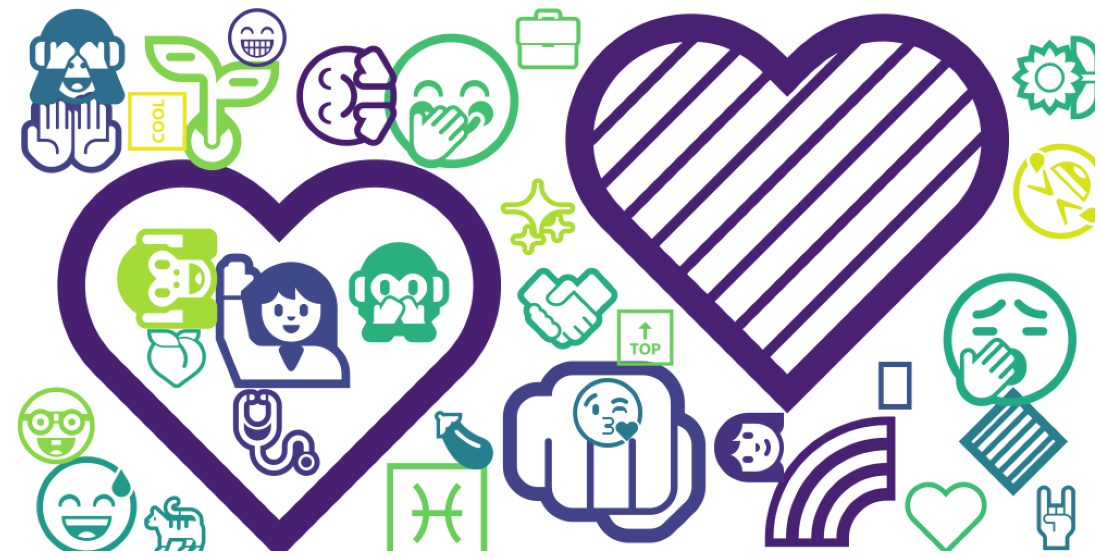

In [404]:

emoji_cloud.generate(" ".join(["{} ".format(e) * number for e, number in top_bio_emojis.items()]))

#### Account Bios Emoji Word Cloud

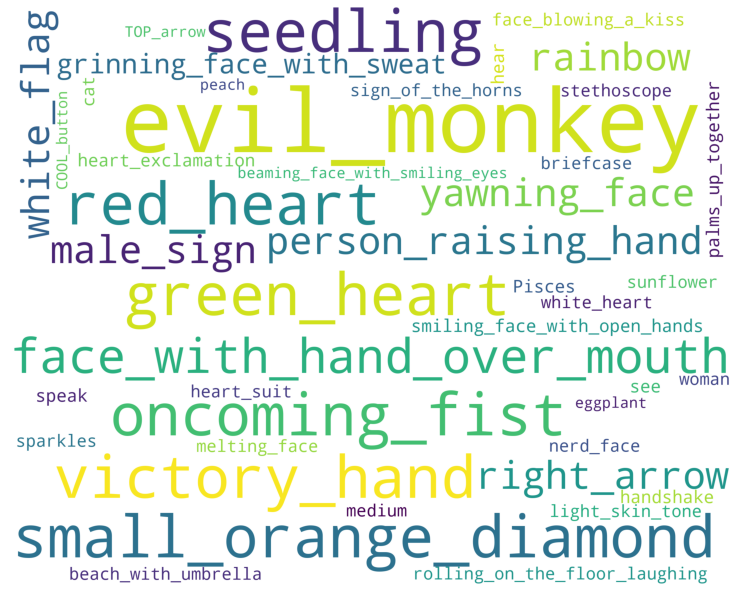

In [405]:
bioWordCloud = WordCloud(
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join([e + " " for e, number in top_bio_emojis_text.items()]))
plt.figure(1,figsize=(13, 13))
plt.imshow(bioWordCloud)
plt.axis('off')
plt.show()

### Top emojis in Tweets

Get the prominent emojis in Tweets

In [406]:
top_tweet_emojis = {
  e:number
  for e, number in collections.Counter(raw_tweets.head(168).apply(extract_emojis).sum()).items()
}

top_tweet_emojis = dict(sorted(top_tweet_emojis.items(), key=lambda x:x[1], reverse=True))

top_tweet_emojis

{'😂': 25,
 '🤣': 4,
 '❗': 4,
 '🤮': 3,
 '👊': 3,
 '😈': 3,
 '🖕': 3,
 '😤': 2,
 '😡': 2,
 '🤔': 2,
 '😅': 1,
 '😖': 1,
 '😑': 1,
 '🙊': 1,
 '🙉': 1,
 '🙈': 1,
 '✌': 1,
 '👉': 1,
 '🔺': 1,
 '😒': 1,
 '👎': 1}

In [407]:
top_tweet_emojis_text = {
  emoji.demojize(e):number
  for e, number in collections.Counter(raw_tweets.head(168).apply(extract_emojis).sum()).items()
}

top_tweet_emojis_text = dict(sorted(top_tweet_emojis_text.items(), key=lambda x:x[1], reverse=True))

top_tweet_emojis_text

{':face_with_tears_of_joy:': 25,
 ':rolling_on_the_floor_laughing:': 4,
 ':red_exclamation_mark:': 4,
 ':face_vomiting:': 3,
 ':oncoming_fist:': 3,
 ':smiling_face_with_horns:': 3,
 ':middle_finger:': 3,
 ':face_with_steam_from_nose:': 2,
 ':enraged_face:': 2,
 ':thinking_face:': 2,
 ':grinning_face_with_sweat:': 1,
 ':confounded_face:': 1,
 ':expressionless_face:': 1,
 ':speak-no-evil_monkey:': 1,
 ':hear-no-evil_monkey:': 1,
 ':see-no-evil_monkey:': 1,
 ':victory_hand:': 1,
 ':backhand_index_pointing_right:': 1,
 ':red_triangle_pointed_up:': 1,
 ':unamused_face:': 1,
 ':thumbs_down:': 1}

In [408]:
tears_of_joy = df_clean["Tweet emojis (text)"].str.contains(':face_with_tears_of_joy:').sum()
rofl = df_clean["Tweet emojis (text)"].str.contains(':rolling_on_the_floor_laughing:').sum()

(tears_of_joy, rofl)

(11, 3)

$11$ tweets contain the 😂 emoji while $3$ tweets contain the 🤣 emoji.

#### Tweet Emoji Cloud

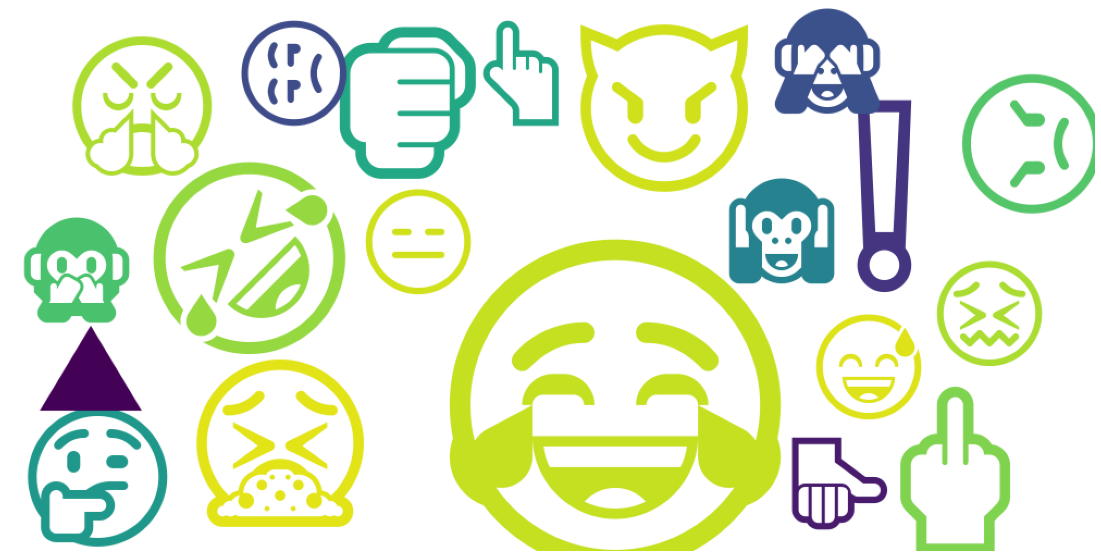

In [409]:

emoji_cloud.generate(" ".join(["{} ".format(e) * number for e, number in top_tweet_emojis.items()]))

#### Tweet Emoji Word Cloud

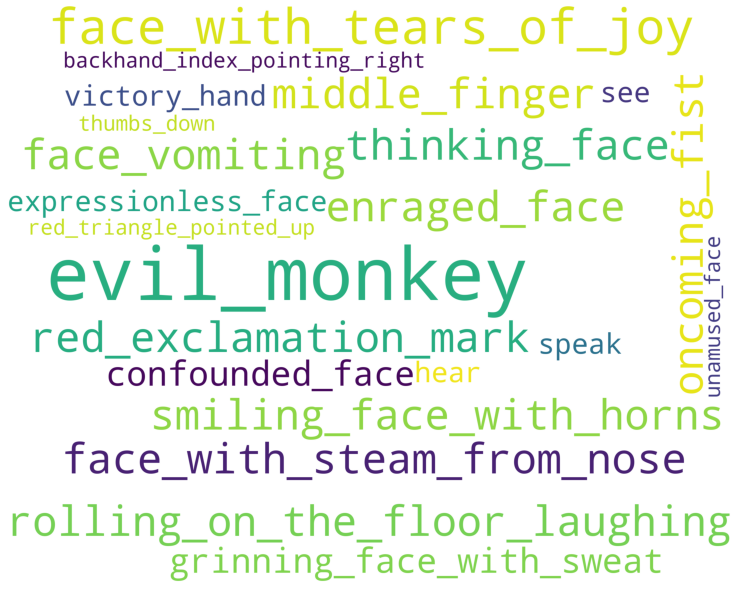

In [410]:
tweetWordCloud = WordCloud(
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join([e + " " for e, number in top_tweet_emojis_text.items()]))
plt.figure(1,figsize=(13, 13))
plt.imshow(tweetWordCloud)
plt.axis('off')
plt.show()

## Tweet Engagements

In [411]:
# Add a new dataframe column called "Engagements"
engagements = df_clean.Likes + df_clean.Replies + df_clean.Retweets
df_clean["Engagements"] = engagements

df_by_engagements = df_clean[["Tweet", "Engagements"]].sort_values(by=["Engagements"], ascending=False)

df_by_engagements.head()

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1845616276.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Tweet,Engagements
125,Yung bang pag recruit ng mga Komunista sa UP a...,5990
87,Pinagbantaan ni Pangulong Duterte na tatanggal...,1969
139,"ROTC will instill, not only discipline, but al...",1274
164,Ay engot! Nagkaroon ng NPA dahil sa ideolohiya...,779
84,Is Leni Robredo employing the same brainwashin...,337


The tweet with the most number of engagements is

In [412]:
df_by_engagements["Tweet"].iloc[0]

'Yung bang pag recruit ng mga Komunista sa UP at iba pang state university upang gawing NPA ang kabataan ay isang Academic Freedom?'

# Visualization<hr>

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1812522727.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'in Year')

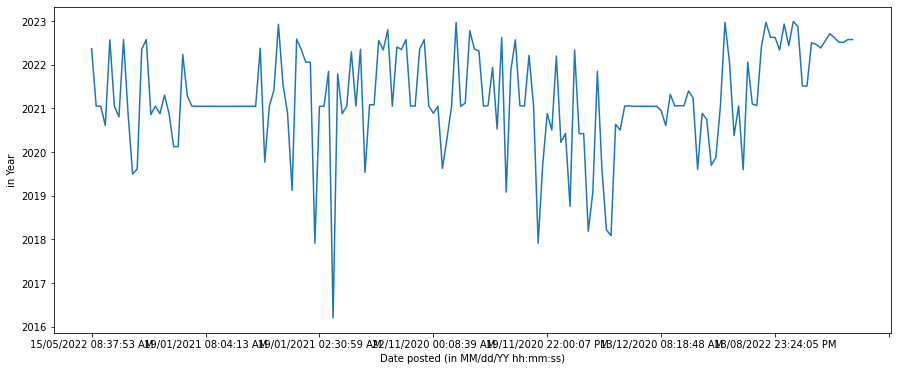

In [413]:
df_clean['Length'] = df_clean["Tweet"].str.len()
df_date_freq = df_clean.copy()
df_date_freq.index = df_subset["Date posted"]
del df_subset["Date posted"]

df_date_freq_plot = df_date_freq["Date posted"].plot(figsize=(15, 6))

df_date_freq_plot.set_xlabel("Date posted (in MM/dd/YY hh:mm:ss)")
df_date_freq_plot.set_ylabel("in Year")

<AxesSubplot:title={'center':'Number of Tweets per Month'}, xlabel='Date posted (3 Months per Tick)', ylabel='Number of Tweets'>

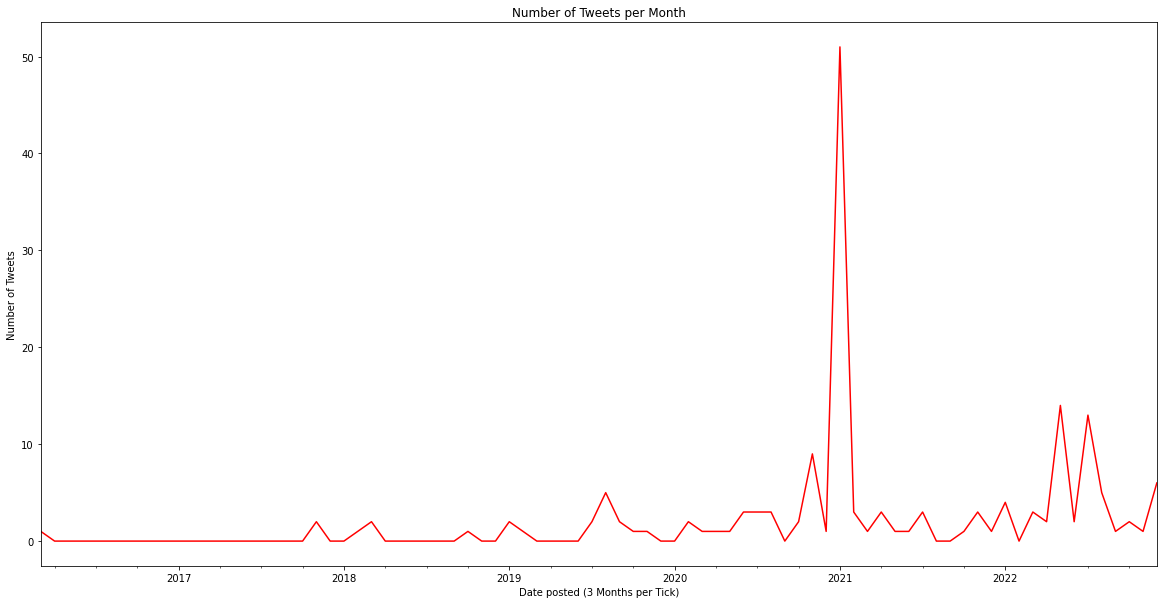

In [433]:
df_date_count = pd.DataFrame({"Date posted": df_date_freq["Date posted"], "count":df_date_freq["ID"]})
df_time = df_date_count.groupby(pd.Grouper(key="Date posted", freq="1M")).count()
df_time_plot = df_time.plot(figsize=(20, 10), color="red")

df_time_plot.set_xlabel("Date posted (3 Months per Tick)")
df_time_plot.set_ylabel("Number of Tweets")
df_time_plot.set_title("Number of Tweets per Month")
df_time_plot.get_legend().remove()
df_time_plot

In [415]:
df
start_date = "2020-04-01"
end_date = "2020-04-30"
mask = (df_clean['Date posted'] > start_date) & (df_clean['Date posted'] <= end_date)
df_clean.loc[mask]['Tweet URL']

78    https://twitter.com/JohnFretz3/status/13511573...
Name: Tweet URL, dtype: object

In [416]:
# df_time = df_clean.copy()
# df_time = df_time.drop(["Followers","Following","Length", "Group", "Account type", "Bio emojis", "Bio emojis (text)", "Tweet emojis", "Tweet emojis (text)"], axis=1).groupby(pd.Grouper(key="Date posted", freq="1Y")).mean()
# df_time.plot(figsize=(20, 10), kind="bar")
# plt.title("Number of interactions per year")
# plt.show()

In [417]:
# df_time = df_time.resample('1M').mean()

# df_time.interpolate(method='spline', order=3).plot()
# plt.title("Interpolation of the number of interactions per year")


# # lines, labels = plt.gca().get_legend_handles_labels()
# # labels = ['spline', 'time']
# # plt.legend(lines, labels, loc='best')
# df_time.interpolate(method='time').plot()
# plt.title("Original data")
# plt.show()

### Tweet Data

In [418]:
lens = df_clean['Tweet'].str.len()
df_clean['Length'] = lens
(lens.mean(), lens.std(), lens.min(), lens.max())

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_35812/1155206828.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(202.375, 77.12760151960947, 23, 335)

In [419]:
df_by_len = df_clean.sort_values(by='Length', ascending=False)
df_by_len

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Replies,Retweets,Rating,Reasoning,Bio emojis,Bio emojis (text),Tweet emojis,Tweet emojis (text),Engagements,Length
53,"=TEXT(D55,""00"")&""-""&ROW(D55)-1",28/03/23 13:50:03,https://twitter.com/BobReye68206730/status/152...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit UP,@BobReye68206730,Bob Reyes,...,0,0,NEED CONTEXT,Statement that CPP-NPA-NDF takes advantage of ...,[],,[],,2,335
166,"=TEXT(D168,""00"")&""-""&ROW(D168)-1",28/03/23 13:50:05,https://twitter.com/gigaigurlmd/status/1553725...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit UP,@gigaigurlmd,Giga Basilio Igurashi🩺,...,0,1,UNPROVEN,Protests during graduation rights were mistake...,[🥱],:yawning_face:,"[😒, 👎]",:unamused_face::thumbs_down:,2,318
136,"=TEXT(D138,""00"")&""-""&ROW(D138)-1",24/03/23 18:43:24,https://twitter.com/gigaigurlmd/status/1549405...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@gigaigurlmd,Giga Basilio Igurashi🩺,...,0,0,UNPROVEN,The allegation regarding UP being infiltrated ...,[🥱],:yawning_face:,[],,12,313
62,"=TEXT(D64,""00"")&""-""&ROW(D64)-1",28/03/23 13:50:27,https://twitter.com/JaredXenos/status/14599243...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,npa recruit university,@JaredXenos,jared zane xenos,...,0,0,UNPROVEN,The allegation regarding UP being infiltrated ...,[],,[],,1,311
47,"=TEXT(D49,""00"")&""-""&ROW(D49)-1",24/03/23 18:43:24,https://twitter.com/ThePaladin33/status/153522...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@ThePaladin33,Sagittarius33,...,0,0,UNPROVEN,Accuses that universities have NPA recruits: h...,[],,[],,0,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,"=TEXT(D45,""00"")&""-""&ROW(D45)-1",21/02/23 17:28:35,https://twitter.com/juz_zuri/status/1553636881...,32,"Delos Reyes, Rey",REDT,Red tagging students from UP,TERORISTA UP NPA,@juz_zuri,pearl,...,0,0,UNPROVEN,Accuses that the said universities are NPA bre...,[],,[],,2,35
42,"=TEXT(D44,""00"")&""-""&ROW(D44)-1",21/02/23 17:26:35,https://twitter.com/samsunguser13/status/15529...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from UP,TERORISTA UP NPA,@samsunguser13,Your Arms🇵🇭/🇩🇪,...,0,0,UNPROVEN,Accuses UP of being terrorists. https://up.edu...,"[🤓, 🫠, ❤️, 💚]",:nerd_face::melting_face::red_heart::green_heart:,[],,22,30
137,"=TEXT(D139,""00"")&""-""&ROW(D139)-1",2023-03-17 09:47:04.485000,https://twitter.com/BaconUpon/status/133031030...,32,"Aloveros, Aira Mae",REDT,Red tagging students from UP,breeding ground ng NPA,@BaconUpon,Eric Son,...,0,0,UNPROVEN,Accuses that UP is a NPA breeding ground https...,[],,[],,0,26
37,"=TEXT(D39,""00"")&""-""&ROW(D39)-1",2023-03-17 09:51:57.063000,https://twitter.com/fey_ded/status/15552647487...,32,"Aloveros, Aira Mae",REDT,Red tagging students from UP,breeding ground ng NPA,@fey_ded,Au.,...,0,0,UNPROVEN,Accuses that UP is a NPA breeding ground https...,[],,[],,18,25


### Distribution of tweet length

This bar graph shows the frequency of tweets at a tweet length interval of 10 characters. Most number of red-tagging tweets are of length within the range of 270-279 characters. This shows that most red taggers maximize the tweet length limit of at most 280 characters. Tweets decrease as we go across the left side of the bar graph. Shorter tweet length may not be sufficient to red-tag university students.

In [420]:
# data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
# layout = go.Layout(
#                   title='Length of tweets and post distribution',                  
#                   xaxis=dict(title='Length'),
#                   yaxis=dict(title='Count'),
#                   bargap=0.1)
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='length histogram')

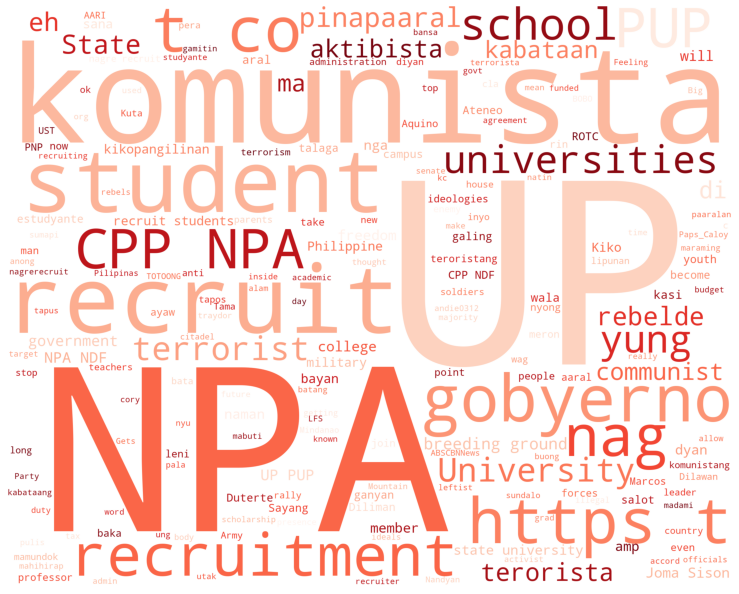

In [421]:
ENG_STOPWORDS = STOPWORDS.copy()
if 'up' in ENG_STOPWORDS:
    ENG_STOPWORDS.remove('up')
wordcloud1 = WordCloud(stopwords=list(ENG_STOPWORDS)+['at','akin',"aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","atin","ating","ka","may",'sa','ang','mga','na','sa','ay','ng','ako','yun','kami','si','ni','kay','kung','yan','pa','lang','ako',"ay","bababa","bago","bakit","bawat","bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang","hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring","maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang","mag","pina","mo","po","niyo","niyong","nang","nasa","pang","ninyo","nalang","taga","jan","pag","ba","dun","nyo","kayo","kayong","nagiging","re","daw","raw","dpt","s","n","u","pong","yang"],
                      background_color='white',
                      width=2500,
                      height=2000,
                      colormap='Reds',  # Set the colormap to 'Reds' for maroon text color
                      prefer_horizontal=1.0  # Adjust horizontal word orientation
                      ).generate(" ".join(df_clean["Tweet"].astype(str)))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

TypeError: set_ticks() got an unexpected keyword argument 'labels'

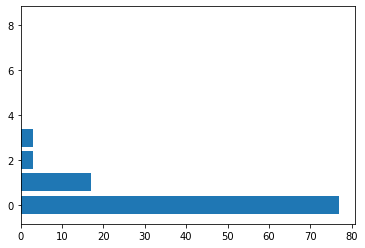

In [422]:
schools = {
        'PUP':['pup', 'polytechnic university of the philippines'],
        'UP':['up','university of the philippines','upd','u.p.','u.p','university of the philippines system','university of the philippines los baños','university of the philippines los banos'],
        'DLSU':['de la salle', 'la salle', 'dlsu', 'de la salle university'],
        'ADMU':['ateneo', 'ateneo de manila', 'ateneo de manila university'],
        'UST':['ust', 'university of santo tomas','u.s.t.','u.s.t','uste'],
        'BSU': ['batangas state university', 'bsu'],
        'NEU': ['new er university', 'neu'],
        'USC': ['university of san carlos', 'usc'],
        'ADU': ['adamson university','adu']
    }

school_count = {item:0 for item in schools}

def get_school(tweet):
    saved_schl = []
    temp = tweet
    for school, keywords in schools.items():
        for keyword in keywords:
            if keyword in temp.lower().split():
                saved_schl.append(school)
                temp.strip(keyword)

    saved_schl = list(set(saved_schl))
    for school in saved_schl:
        school_count[school] += 1

    return saved_schl


df_clean['school'] = df_clean['Tweet'].apply(get_school)
df_clean['school']
school_count

school_count = dict(sorted(school_count.items(), key=lambda x:x[1], reverse=True))


# df_schools = pd.DataFrame({
#     'Schools' : [item for item in school_count],
#     'Count' : [school_count[item] for item in school_count]
# })

schools_grph = tuple(school_count.keys())
y_pos = np.arange(len(schools_grph))  
count = [school_count[item] for item in school_count]
fig, ax = plt.subplots()

hbars = ax.barh(y_pos, count, align='center')
ax.set_yticks(y_pos, labels=schools_grph)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mentions')
ax.xaxis.set_ticks(np.arange(0, 101, 5))
ax.set_title('Top Universities Mentioned in Red-Tag Tweets')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=100)  # adjust xlim to fit labels


Text(0.5, 0, 'Length (number of characters)')

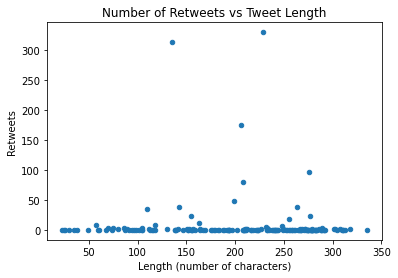

In [423]:
df_eng_len = pd.DataFrame(
    {'Retweets': df_clean.Retweets,
     'Length': lens
    })


plot_eng_len = df_eng_len.plot.scatter(x='Length', y='Retweets')
plot_eng_len.set_title("Number of Retweets vs Tweet Length")
plot_eng_len.set_xlabel("Length (number of characters)")


The scatterplot above displays the relationship between the number of retweets and the length of the tweet. Tweets with retweet count $\geq 50$ would most likely fall under a tweet length range of $200 - 300$. We should take note, however, that most tweets, regardless of tweet length, hold a retweet count of $0$.

Text(0.5, 0, 'Engagements (Likes + Replies + Retweets)')

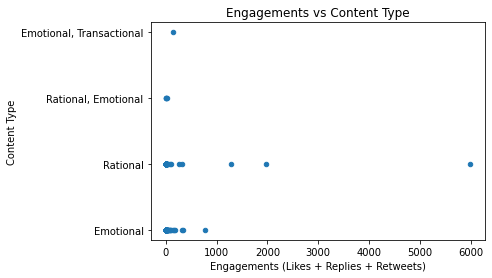

In [424]:
df_cont_eng = pd.DataFrame(
    {'Engagements': engagements,
     'Content Type': df_clean["Content type"]
    })


plot_cont_eng = df_cont_eng.plot.scatter(x='Engagements', y='Content Type')
plot_cont_eng.set_title("Engagements vs Content Type")
plot_cont_eng.set_xlabel("Engagements (Likes + Replies + Retweets)")

The scatterplot above displays the relationship between the content type and the number of engagements of the tweet. The content with a large number of engagements $(\gtrapprox 1000)$ tend to fall under the `Rational` content type despite the top content type being `Emotional` with $113$ tweets possessing this type, followed by $59$ and $1$ of `Rational` and `Transactional`, respectively. This can infer that most twitter audiences tend to react more on a tweet that is  informational, functional, educational, or current event. Tweets that trigger rational thinking may engage more audiences than those that trigger emotions or invoke transactions. 

 Note that the number of engagements of a tweet is defined in this study as the __sum__ of Likes, Replies, Retweets, and Replies a tweet has obtained. 

Text(0, 0.5, 'Engagements (Likes + Replies + Retweets + Replies)')

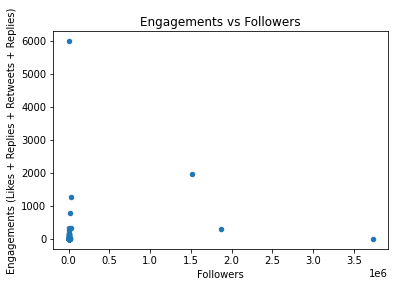

In [425]:
df_foll_eng = pd.DataFrame(
    {'Followers': df_clean["Followers"],
     'Engagements': df_clean["Engagements"]     
    })


plot_foll_eng = df_foll_eng.plot.scatter(x='Followers', y='Engagements')
plot_foll_eng.set_title("Engagements vs Followers")
plot_foll_eng.set_ylabel("Engagements (Likes + Replies + Retweets + Replies)")

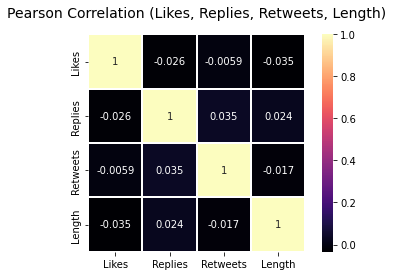

In [426]:
df_heat_map = pd.DataFrame({
    'Likes' : df_clean['Likes'],
    'Replies' : df_clean['Replies'],
    'Retweets' : df_clean['Retweets'],
    'Length' : df_clean['Length'],
})

colormap = plt.cm.magma
plt.title('Pearson Correlation (Likes, Replies, Retweets, Length)', y=1.05, size=14)
sns.heatmap(df_heat_map.astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

The matrix above is a visual representation of the correlation between number of Likes, Replies, and Retweets, and Length of tweet. Pearson coefficient values show a **negligible** correlation $(r < 0.10)$ among these variables. This shows that a lengthy tweet does not necessarily imply a high number of Likes, a high number of Replies, and a high number of Retweet, and so forth.

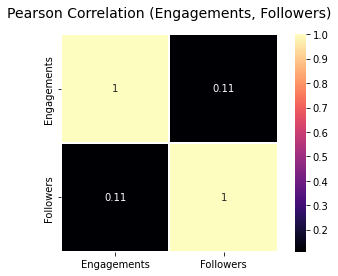

In [427]:
df_heat_map = pd.DataFrame({
    'Engagements' : df_clean['Engagements'],
    'Followers' : df_clean['Followers'],
})

colormap = plt.cm.magma
plt.title('Pearson Correlation (Engagements, Followers)', y=1.05, size=14)
sns.heatmap(df_heat_map.astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

The matrix above is a visual representation of the correlation between the tweet's Engagements and the number of Followers of the tweet author. Pearson coefficient values show a **weak** correlation $(0.10 < r < 0.39)$ among these variables. This implies that accounts with a greater number of followers may, but not strictly, tend to have more engagements than those accounts with less followers.

## Stemming and Lematization

In [428]:
# Handle Emojis [2]
url_emoji = "https://drive.google.com/uc?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v"
df_emoji = pd.read_pickle(url_emoji)
df_emoji = {v: k for k, v in df_emoji.items()}

def emoji_to_word(text):
  for emot in df_emoji:
    text = re.sub(r'('+emot+')', "_".join(df_emoji[emot].replace(",","").replace(":","").split()), text)
  return text

# Handle Emoticons [2]
url_emote = "https://drive.google.com/uc?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE"
df_emote = pd.read_pickle(url_emote)

def emote_to_word(text):
    for emot in df_emote:
        text = re.sub(u'('+emot+')', "_".join(df_emote[emot].replace(",","").split()), text)
        text = text.replace("<3", "heart" ) # not included in emoticons database
    return text

texts = copy.deepcopy(df_clean['Tweet'])
texts.apply(emoji_to_word)
texts.apply(emote_to_word)
texts.str.lower()



0      school crack down! state university ang pinaka...
1      @ilda_talk dapat talaga iniexpel ang mga ito s...
2      @bethangsioco @pinoyakoblog ang kakapal ng muk...
3      @gmanews @_jamesja @dzbb the future npas my go...
4      i thought the term "majority" should be replac...
                             ...                        
163    @tishacm pup shud be made liable. isang taon l...
164    ay engot! nagkaroon ng npa dahil sa ideolohiya...
165    @mysocmedlyf25 @paps_caloy kaya puro young ang...
166    @paps_caloy @bongbongmarcos @indaysara commenc...
167    @paps_caloy @bongbongmarcos @indaysara kaya wa...
Name: Tweet, Length: 168, dtype: object

In [429]:
# INSTALL: pip install googletrans==3.1.0a0
!pip install googletrans==3.1.0a0

In [430]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from googletrans import Translator

translator = Translator()
texts_en = texts.apply(translator.translate)
texts_en

KeyboardInterrupt: 

In [ ]:
texts_en = pd.DataFrame({
    'Tweet' : [elem.text for elem in texts_en]
})

In [ ]:
# texts_tok = [word_tokenize(text) for text in texts_en['Tweet']]
# texts_filtered = [[word for word in tok if word.lower() not in stopwords.words('english')] for tok in texts_tok]
# texts_joined = [' '.join(filt) for filt in texts_filtered]
# texts_joined

In [ ]:
# from nltk.stem import PorterStemmer, WordNetLemmatizer

# # Initialize the stemmer and lemmatizer
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

# texts_stem, texts_lem = [], []

# def stem_lem(text):
#   words = text.split()

#   # Stem each word
#   stemmed_words = [stemmer.stem(word) for word in words]
  
#   # Lemmatize each word
#   lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  
#   # Return the stemmed and lemmatized words as a tuple
#   texts_stem.append(stemmed_words)
#   texts_lem.append(lemmatized_words)

#   return (stemmed_words, lemmatized_words)

# # Process each text in the array
# processed_texts = [stem_lem(t) for t in texts_joined]
# df_sl = pd.DataFrame({
#   'Original' : df_clean['Tweet'],
#   'Stemmed'  : texts_stem,
#   'Lemmatized' : texts_lem,
# })

# df_sl

## Appendix

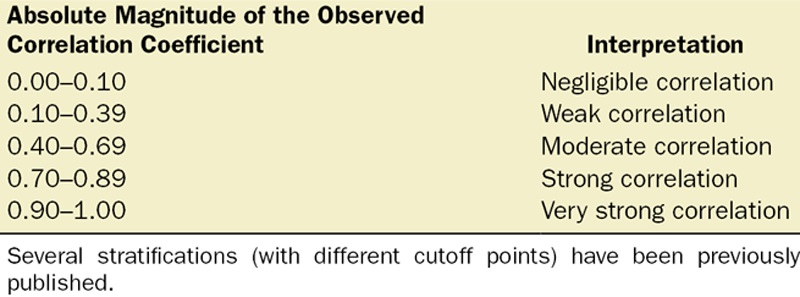

*Table 1: Example of a Conventional Approach to Interpreting a Correlation Coefficient*

Source: https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx

# Stat Analysis: Chi-Square

**Hypothesis Formulation:**

Null hypothesis (H0): There is no association between the target of red tag tweets and the mention of UP.

Alternative hypothesis (H1): UP is the dominating target of red tag tweets.

The tweets were manually tagged as follows:
- Tweets mentioning UP.
- Tweets mentioning a school other than UP.
- Tweets mentioning both UP and  school other than UP.
- Tweets that do not mention any school names.

In [ ]:

# Note that there are may be tweets that are mentioning both
total_tweet_count = df_clean.shape[0]
up_tweet_count = df_clean['UP'].sum()
clg_tweet_count = df_clean['OTHER SCHOOLS'].sum()
both_tweet_count = df_clean['BOTH'].sum()
non_clg_tweet_count = df_clean['NONE'].sum()



observed_freq = np.array([up_tweet_count, clg_tweet_count, both_tweet_count, non_clg_tweet_count])


print("Total Tweet Count", total_tweet_count)
print("Sum of Observed Freq", up_tweet_count+ clg_tweet_count+ both_tweet_count+ non_clg_tweet_count)
observed_freq


Total Tweet Count 168
Sum of Observed Freq 168


array([87,  9, 22, 50], dtype=int64)

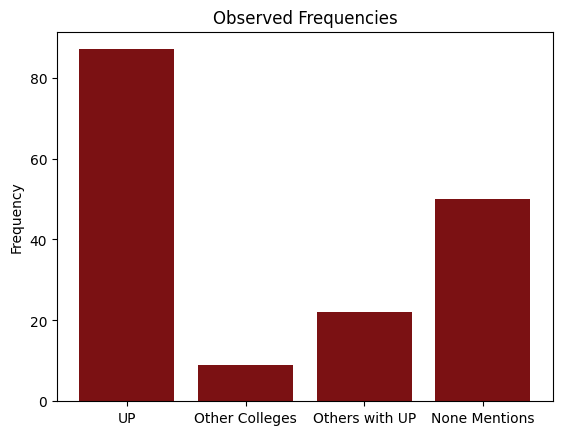

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the categories and their corresponding frequencies
categories = ['UP', 'Other Colleges', 'Others with UP', 'None Mentions']

# Set the position of the bars on the x-axis
x = np.arange(len(categories))

# Plot the observed frequencies
fig, ax = plt.subplots()
rects = ax.bar(x, observed_freq, color='#7B1113')

# Add labels, title, and legend
ax.set_ylabel('Frequency')
ax.set_title('Observed Frequencies')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Display the plot
plt.show()


Compute the Expected Value

In [ ]:
up_expected_frequency = up_tweet_count / total_tweet_count
clg_expected_frequency = clg_tweet_count / total_tweet_count
both_expected_frequency = both_tweet_count/total_tweet_count
non_clg_expected_frequency = non_clg_tweet_count / total_tweet_count


expected_freq = np.array([up_expected_frequency, clg_expected_frequency, both_expected_frequency, non_clg_expected_frequency])

expected_freq.sum()
expected_freq
# Address discrepancy in sum
expected_sum = np.sum(observed_freq)
expected_freq *= expected_sum / np.sum(expected_freq)

In [ ]:
print("Observed Frequency")
observed_freq

Observed Frequency


array([87,  9, 22, 50], dtype=int64)

`scipy.stats.chisquare` is used to calculate a one-way chi-square test.

The chi-square test tests the null hypothesis that the categorical data has the given frequencies.

Note that for `f_exp`, Expected frequencies in each category. By default the categories are assumed to be equally likely.

In [ ]:
from scipy.stats import chisquare
chi2_stat, p_value = chisquare(observed_freq)

print("Chi-square statistic:", chi2_stat)
print("p-value:", p_value)

Chi-square statistic: 85.19047619047618
p-value: 2.3619449832724064e-18


In [ ]:
# Compare p-value with significance level (alpha)
alpha = 0.05  # Example alpha value
degrees_of_freedom = observed_freq.shape[0]-1

Perform the chi-square test

Compare the calculated chi-square value with the critical chi-square value.

In [ ]:
print("Alpha:", alpha)
print("Degrees of Freedom:", degrees_of_freedom)
# print("Critical Chi-square Value:", critical_chi2_value)
print("Chi-square Statistic:", chi2_stat)
print("p-value:", p_value)

Alpha: 0.05
Degrees of Freedom: 3
Chi-square Statistic: 85.19047619047618
p-value: 2.3619449832724064e-18


In [ ]:
if p_value < alpha:
    print("Reject the null hypothesis. UP is the dominating target of red tag tweets.")
else:
    print("Fail to reject the null hypothesis. No significant evidence to conclude that UP is the dominating target of red tag tweets.")

Reject the null hypothesis. UP is the dominating target of red tag tweets.


Based on the chi-square test results, we reject the null hypothesis. The calculated p-value is below the significance level, indicating a significant association between the target of red tag tweets and the mention of UP. Therefore, we have found compelling evidence to support the claim that **UP is the dominating target of red tag tweets.**